In [9]:
import pandas as pd
import numpy as np

data_path = "./dataset/datasetTC4.dat"

data = np.loadtxt(data_path)
print(data.shape)
data

(310, 6)


array([[ 63.03,  22.55,  39.61,  40.48,  98.67,  -0.25],
       [ 39.06,  10.06,  25.02,  29.  , 114.41,   4.56],
       [ 68.83,  22.22,  50.09,  46.61, 105.99,  -3.53],
       ...,
       [ 61.45,  22.69,  46.17,  38.75, 125.67,  -2.71],
       [ 45.25,   8.69,  41.58,  36.56, 118.55,   0.21],
       [ 33.84,   5.07,  36.64,  28.77, 123.95,  -0.2 ]])

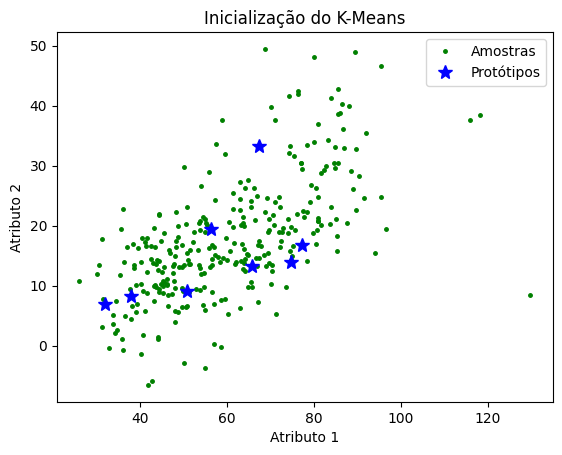

In [10]:
import matplotlib.pyplot as plt

K = 8 # Número de protótipos
epochs = 100 # Número de iterações

N, p = data.shape

idxs = np.random.choice(N, K, replace=False) # Aleatoriedade dos protótipos
prototypes = data[idxs, :] # Protótipos definidos

plt.figure()
plt.plot(data[:, 0], data[:, 1], '.g', markersize=5)
plt.plot(prototypes[:, 0], prototypes[:, 1], 'b*', markersize=10)
plt.xlabel('Atributo 1')
plt.ylabel('Atributo 2')
plt.title('Inicialização do K-Means')
plt.legend(['Amostras', 'Protótipos'])
plt.show()

In [11]:
SSD = np.zeros(epochs)

for epoch in range(epochs):
    
    dist = np.zeros((N, K))
    for t in range(N):
        dist[t, :] = np.linalg.norm(data[t, :] - prototypes, axis=1)
    
    Icluster = np.argmin(dist, axis=1)

    SSD[epoch] = np.sum(np.min(dist, axis=1)**2)

    # Particiona dados em K subconjuntos e atualiza protótipo correspondente
    for k in range(K):
        I = np.where(Icluster == k)[0]
        Particao = data[I, :]
        prototypes[k, :] = np.mean(Particao, axis=0)

<Figure size 640x480 with 0 Axes>

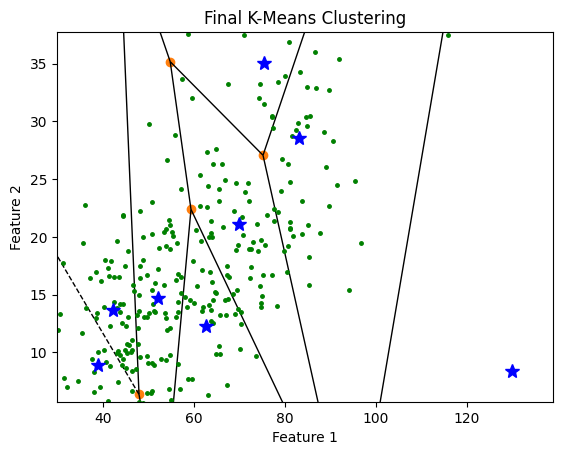

In [12]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Mostra posição final dos protótipos
plt.figure()

# plt.voronoi(prototypes[:, 0], proto[:, 1])
vor = Voronoi(prototypes[:,:2])
fig = voronoi_plot_2d(vor)
plt.plot(data[:, 0], data[:, 1], '.g', markersize=5)
plt.plot(prototypes[:, 0], prototypes[:, 1], 'b*', markersize=10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Final K-Means Clustering')
plt.show()

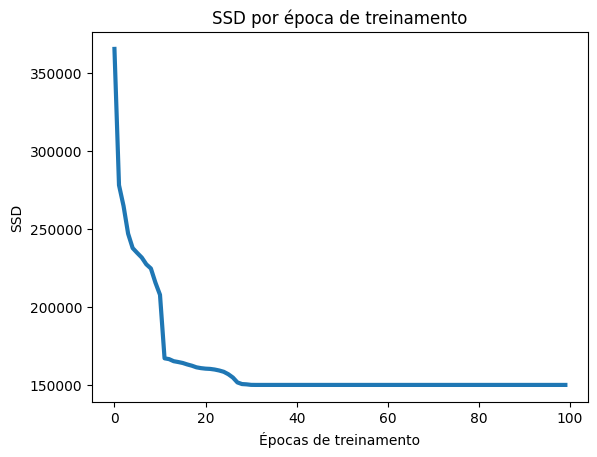

In [13]:
# Mostra evolução do SSD ao longo das épocas de treinamento
plt.figure()
plt.plot(SSD, linewidth=3)
plt.xlabel('Épocas de treinamento')
plt.ylabel('SSD')
plt.title('SSD por época de treinamento')
plt.show()

In [14]:
from sklearn.metrics import pairwise_distances

def dunn_index(X, Icluster):
    """
    Índice de Validação Dunn para avaliação de clusters.
    Quanto maior o valor, melhor.

    Parameters:
    - X: Conjunto de dados.
    - Icluster: Vetor de índices de cluster atribuídos a cada ponto.

    Returns:
    - Dunn Index.
    """
    num_clusters = len(np.unique(Icluster))
    if num_clusters == 1:
        return np.inf
    
    min_intercluster_distance = np.inf
    max_intracluster_diameter = 0

    for i in range(1, num_clusters + 1):
        cluster_points = X[Icluster == i]
        intracluster_distances = pairwise_distances(cluster_points)
        max_intracluster_diameter = max(np.max(intracluster_distances), max_intracluster_diameter)

        for j in range(i + 1, num_clusters + 1):
            other_cluster_points = X[Icluster == j]
            intercluster_distance = np.min(pairwise_distances(cluster_points, other_cluster_points))
            min_intercluster_distance = min(min_intercluster_distance, intercluster_distance)

    dunn_index = min_intercluster_distance / max_intracluster_diameter
    return dunn_index

def davies_bouldin_index(X, Icluster):
    """
    Índice de Validação Davies-Bouldin para avaliação de clusters.
    Quanto menor o valor, melhor.

    Parameters:
    - X: Conjunto de dados.
    - Icluster: Vetor de índices de cluster atribuídos a cada ponto.

    Returns:
    - Davies-Bouldin Index.
    """
    num_clusters = len(np.unique(Icluster))
    if num_clusters == 1:
        return 0.0

    centroids = [np.mean(X[Icluster == i], axis=0) for i in range(1, num_clusters + 1)]

    # Calcula as distâncias médias intracluster
    avg_intracluster_distances = []
    for i in range(num_clusters):
        cluster_points = X[Icluster == i + 1]
        intracluster_distances = pairwise_distances(cluster_points, [centroids[i]])
        avg_intracluster_distances.append(np.mean(intracluster_distances))

    # Calcula as distâncias médias intercluster normalizadas
    intercluster_distances = pairwise_distances(centroids)
    normalized_intercluster_distances = (intercluster_distances + intercluster_distances.T) / avg_intracluster_distances

    # Ignora a diagonal principal (distâncias intracluster)
    np.fill_diagonal(normalized_intercluster_distances, np.inf)

    davies_bouldin_index = np.max(np.sum(normalized_intercluster_distances, axis=1)) / num_clusters
    return davies_bouldin_index

def calinski_harabasz_index(X, Icluster):
    """
    Índice de Validação Calinski-Harabasz para avaliação de clusters.
    Quanto maior o valor, melhor.

    Parameters:
    - X: Conjunto de dados.
    - Icluster: Vetor de índices de cluster atribuídos a cada ponto.

    Returns:
    - Calinski-Harabasz Index.
    """
    num_clusters = len(np.unique(Icluster))
    if num_clusters == 1:
        return np.inf

    centroids = [np.mean(X[Icluster == i], axis=0) for i in range(1, num_clusters + 1)]

    overall_centroid = np.mean(X, axis=0)

    # Calcula a soma dos quadrados intracluster
    within_cluster_ss = sum(np.sum(pairwise_distances(X[Icluster == i]) ** 2) for i in range(1, num_clusters + 1))

    # Calcula a soma dos quadrados intercluster
    between_cluster_ss = sum(len(X[Icluster == i]) * np.sum((centroids[i - 1] - overall_centroid) ** 2) for i in range(1, num_clusters + 1))

    # Calcula o número total de pontos
    total_points = X.shape[0]

    # Calcula o número total de clusters
    total_clusters = num_clusters

    # Calcula o Calinski-Harabasz Index
    calinski_harabasz_index = (between_cluster_ss / (total_clusters - 1)) / (within_cluster_ss / (total_points - total_clusters))
    return calinski_harabasz_index

In [22]:
# Após o treinamento do K-médias
print(Icluster)
Icluster = np.argmin(Dist2, axis=1) + 1  # Supondo que os índices de cluster começam em 1

# Calcular índices de validação
dunn = dunn_index(data, Icluster)
davies_bouldin = davies_bouldin_index(data, Icluster)
calinski_harabasz = calinski_harabasz_index(data, Icluster)

print("Dunn Index:", dunn)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)

[4 3 4 4 1 3 1 1 2 3 1 3 3 3 4 1 4 1 3 3 2 2 4 1 3 3 3 3 3 4 3 3 3 3 4 3 2
 3 3 3 3 1 3 4 4 3 3 3 3 3 3 4 3 3 3 3 1 3 3 1 8 7 2 6 4 6 6 8 4 6 6 7 8 6
 8 7 7 6 6 3 8 8 8 8 8 2 4 2 2 6 6 6 8 6 8 7 8 6 8 6 6 6 6 6 7 4 6 8 6 6 6
 8 6 6 7 5 6 8 4 6 6 8 8 6 6 6 6 8 8 6 3 4 6 8 8 8 8 8 8 8 6 7 8 7 6 8 8 6
 6 6 6 6 6 6 3 6 8 6 6 6 8 6 8 8 2 8 6 6 8 1 6 6 6 6 4 6 6 6 8 8 2 6 8 8 8
 8 8 6 8 8 6 8 7 6 6 6 6 7 6 6 6 7 7 6 6 7 8 8 8 3 3 4 2 2 1 2 1 2 1 4 3 4
 6 4 4 4 4 4 1 2 4 1 2 2 2 4 4 4 4 2 1 2 1 1 4 2 3 3 1 3 1 2 1 4 4 6 4 1 1
 4 1 4 3 1 4 2 1 1 4 3 2 3 1 1 1 4 1 4 1 2 1 4 1 2 4 4 4 1 4 1 3 1 1 2 1 2
 3 3 4 4 1 4 3 1 2 1 3 4 1 1]
Dunn Index: 0.05015104906906182
Davies-Bouldin Index: inf
Calinski-Harabasz Index: 1.7780641225827156


/tmp/ipykernel_54045/4157113523.py:62: RuntimeWarning: divide by zero encountered in divide
  normalized_intercluster_distances = (intercluster_distances + intercluster_distances.T) / avg_intracluster_distances
/tmp/ipykernel_54045/4157113523.py:62: RuntimeWarning: invalid value encountered in divide
  normalized_intercluster_distances = (intercluster_distances + intercluster_distances.T) / avg_intracluster_distances
